## HUDF with astropy
#### import numpy, sep and astropy

In [21]:
import numpy as np
import sep
import astropy.io.fits as ast

#### import matplotlib libraries
#### additional setup for reading the test image and displaying plots

In [22]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

rcParams['figure.figsize'] = [10.,8.]

#### read image into standard 2-d numpy array

In [23]:
with ast.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits") as hdul:
    data = hdul[0].data

#### show the image

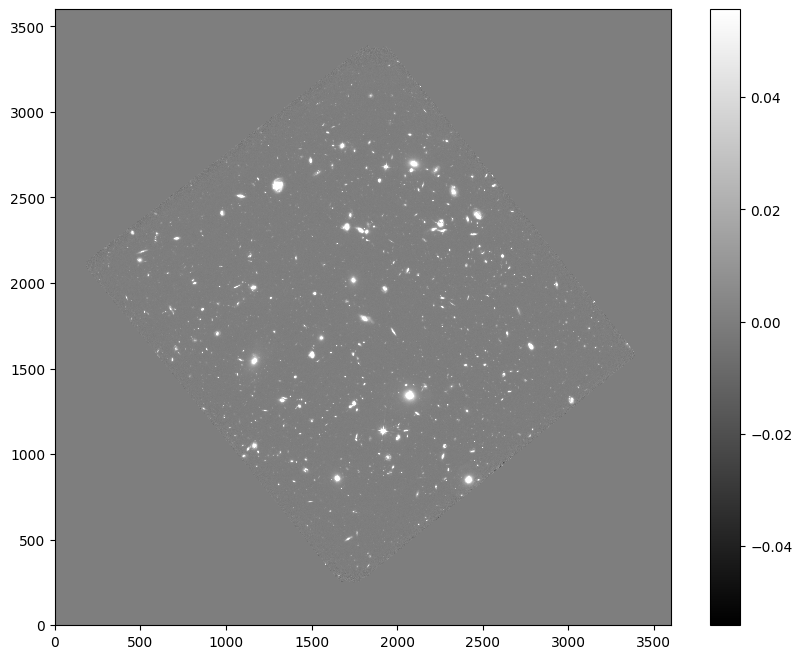

In [24]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation = "nearest", cmap = "gray", vmin = m -s, vmax = m + s, origin = "lower")
plt.colorbar();
plt.savefig("image1_hudf.png", bbox_inches = "tight", dpi = 400)

#### measure a spatially varying background on the image

In [25]:
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

#### get a "global" mean and noise of the image background:

In [26]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


#### evaluate background as 2-d array, same size as original image

In [27]:
bkg_image = bkg.back()
#bkg_image = np.array(bkg) is the same

#### show the background

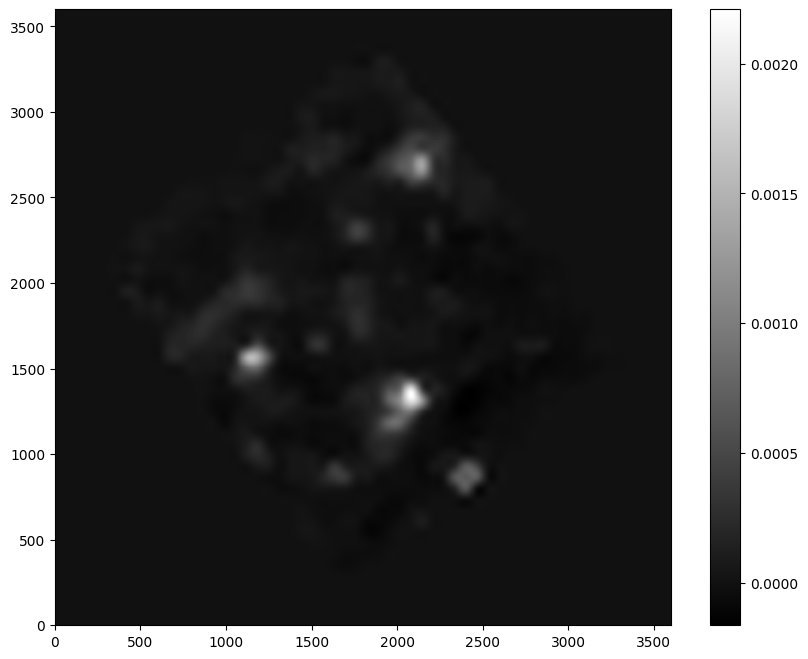

In [28]:
plt.imshow(bkg_image, interpolation = "nearest", cmap = "gray", origin = "lower")
plt.colorbar();
plt.savefig("image2_hudf.png", bbox_inches = "tight", dpi = 400)

#### evaluate the background noise as 2-d array, same size

In [29]:
bkg_rms = bkg.rms()

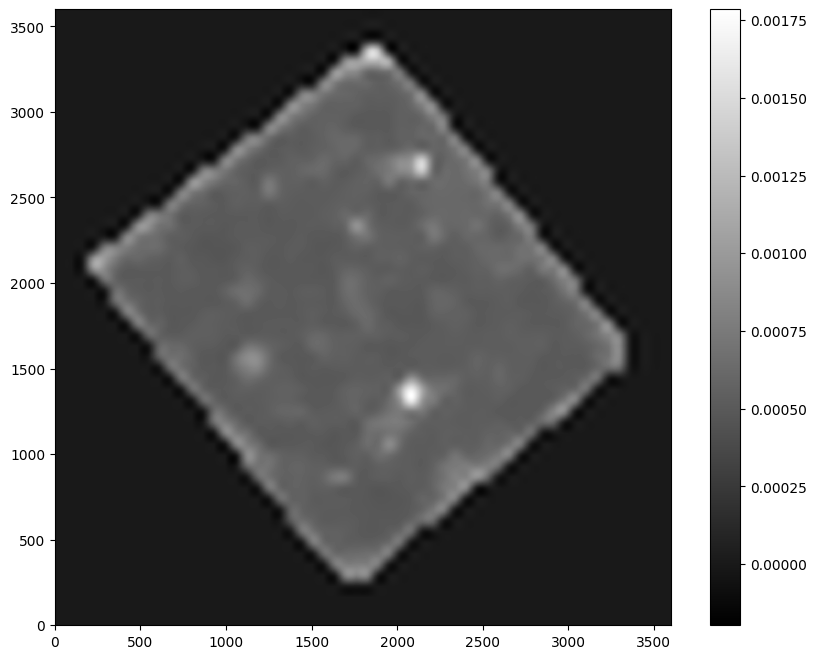

In [30]:
#show the background noise
plt.imshow(bkg_rms, interpolation = "nearest", cmap = "gray", origin = "lower")
plt.colorbar();
plt.savefig("image3_hudf.png", bbox_inches = "tight", dpi = 400)

#### subtract the background

In [31]:
data_sub = data - bkg
#or bkg.subfrom(data)

#### run object detection on the background-subtracted data

In [32]:
objects = sep.extract(data_sub, 1.5, err = bkg.globalrms)

#### sep.extract hasmany options for controlling detection threshold, pixel masking, filtering and object deblending
#### objects is a NumPy structured array with many fields

In [33]:
#how many objects were detected
len(objects)

8641

#### to check where the detected objects are, we'll over-plot the object coordinates with some basic shape parameters on the image

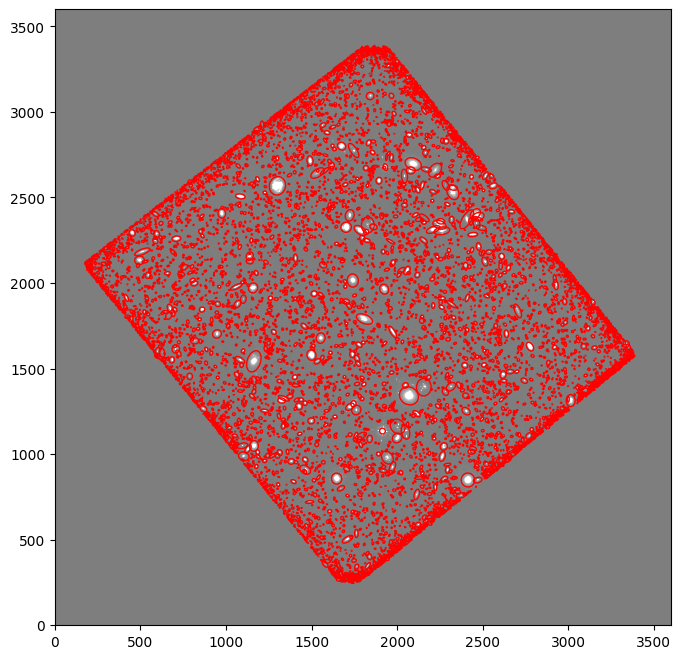

In [34]:
from matplotlib.patches import Ellipse

#plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation = "nearest", cmap = "gray", vmin = m - s, vmax = m + s, origin = "lower")

#plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy = (objects["x"][i], objects["y"][i]), width = 6*objects["a"][i], height = 6*objects["b"][i], angle = objects["theta"][i] * 180. / np.pi)
    e.set_facecolor("none")
    e.set_edgecolor("red")
    ax.add_artist(e)

plt.savefig("image4_hudf.png", bbox_inches = "tight", dpi = 400)

#### available fields

In [35]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

#### perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [36]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects["x"], objects["y"], 3.0, err = bkg.globalrms, gain = 1.0)
#flux, fluxerr and flag are all 1-d arrays with one entry per objects

#### show the first 10 objects results:

In [37]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


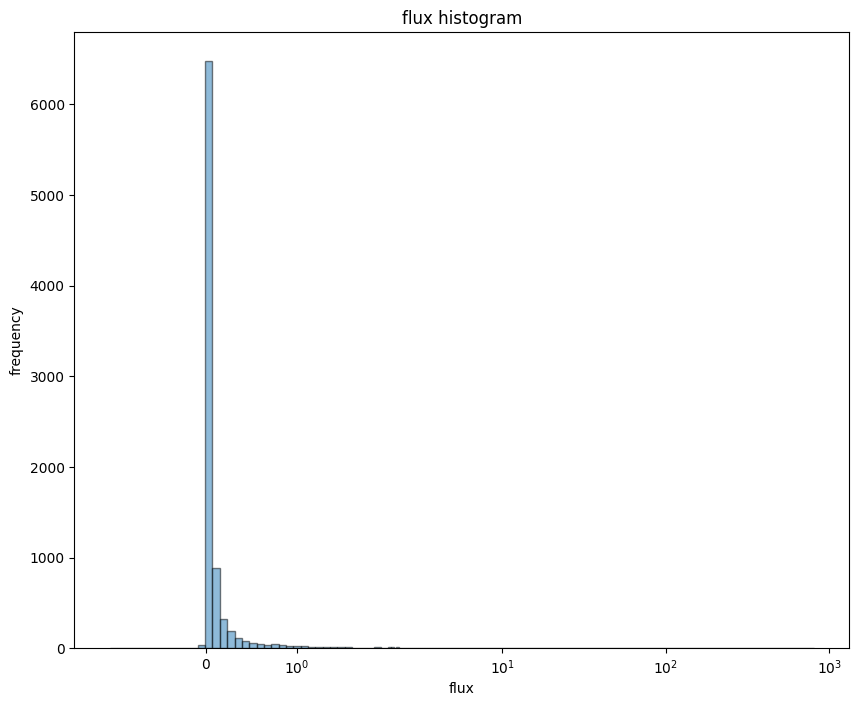

In [38]:
#fluxes = np.linspace(0, flux[8639], len(objects))
plt.hist(flux, bins = 10000, edgecolor = "black", alpha = 0.5)
plt.xlabel("flux")
plt.ylabel("frequency")
plt.xscale("symlog")
plt.title("flux histogram")

plt.savefig("HUDF_hist.png", bbox_inches = "tight", dpi = 400)

plt.show()

In [39]:
#mean, median and std of fluxes
f_mean = np.mean(flux)
f_median = np.median(flux)
f_std = np.std(flux)

print(f"Mean: {f_mean}\nMedian: {f_median}\nStandard Deviation: {f_std}")

Mean: 0.36181040728805286
Median: 0.030961835534690188
Standard Deviation: 9.242994159843427


In [40]:
#largest outlier
f_outlier = np.abs(flux - f_mean) > 2 * f_std
f_out_ind = np.argmax(np.abs(flux - f_mean))
f_out_val = flux[f_out_ind]
out_std = (f_out_val - f_mean)/f_std

print(f"Largest Outlier: {f_out_val}\nIndex of Largest Outlier: {f_out_ind}")
print(f"The Largest Outlier is {out_std} Standard Deviations from the Mean")

Largest Outlier: 807.2972835731507
Index of Largest Outlier: 2065
The Largest Outlier is 87.30238916212102 Standard Deviations from the Mean


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


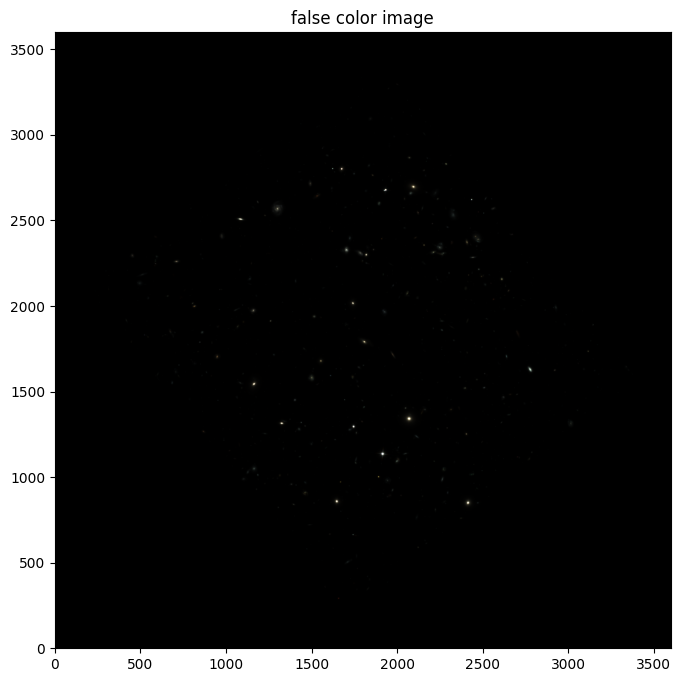

In [41]:
#loading fits representing rgb
red_f160w = ast.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")
green_f125w = ast.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
blue_f105w = ast.getdata("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

rgb_img = np.stack([red_f160w, green_f125w, blue_f105w], axis = -1)

#display
plt.imshow(rgb_img, origin = "lower")
plt.title("false color image")
plt.savefig("HUDF_falsecolor.png", bbox_inches = "tight", dpi = 400)
plt.show()